In [5]:
# パッケージのimport
import glob
import os
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

print(os.listdir('./images/'))

['.DS_Store', 'ボツ', 'cat', 'dog']


In [6]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
SEED=1234

In [7]:
class ImageTransform():
    
    def __init__(self,resize, mean, std,degrees=30):
        self.data_transform = {
            'train':transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                #transforms.RandomAffine(degrees=degrees),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std)
            ]),
            'val':transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

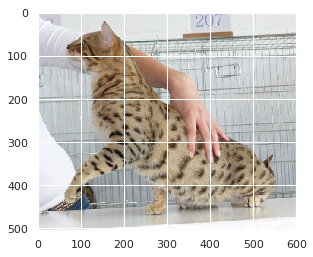

3


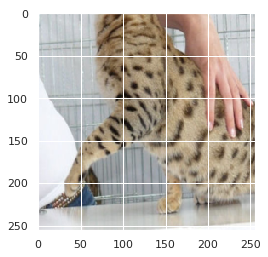

In [8]:
# 画像の読み込み
import cv2

image_file_path = './images/cat/Bengal_2.jpg'
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase='train')

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
print(img_transformed.shape[2])
plt.imshow(img_transformed)
plt.show()

In [9]:
# ファイルパスのリストを作る
def make_datapath_list(name='cat'):
    rootpath = './images/'
    target_path = os.path.join(rootpath+name+'/*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list

cat_list = make_datapath_list()

./images/cat/*.jpg


In [10]:
cat_names = []
for file in cat_list:
    name = file.split('/')[3].split('_')[0]
    cat_names.append(name)

cat_names = set(cat_names)
print(cat_names)

{'Bombay', 'British', 'Ragdoll', 'Siamese', 'Birman', 'Sphynx', 'Egyptian', 'Maine', 'Russian', 'Persian', 'Bengal', 'Abyssinian'}


In [11]:
labels = []
for file in cat_list:
    if 'Abyssinian' in file:
        labels.append(0)
    elif 'Bengal' in file:
        labels.append(1)
    elif 'Birman' in file:
        labels.append(2)
    elif 'Bombay' in file:
        labels.append(3)
    elif 'British' in file:
        labels.append(4)
    elif 'Egyptian' in file:
        labels.append(5)
    elif 'Maine' in file:
        labels.append(6)
    elif 'Persian' in file:
        labels.append(7)
    elif 'Ragdoll' in file:
        labels.append(8)
    elif 'Russian' in file:
        labels.append(9)
    elif 'Siamese' in file:
        labels.append(10)
    elif 'Sphynx' in file:
        labels.append(11)

In [12]:
print(len(cat_list))
print(len(labels))

2389
2389


### Dataset作成

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cat_list, labels, stratify=labels, random_state=SEED, shuffle=True,test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=SEED, shuffle=True,test_size=0.1)
print('X_train : ',len(X_train))
print('X_val : ',len(X_val))
print('X_test : ',len(X_test))
print('y_train : ',len(y_train))
print('y_val : ',len(y_val))
print('y_test : ',len(y_test))

X_train :  1935
X_val :  215
X_test :  239
y_train :  1935
y_val :  215
y_test :  239


In [14]:
class catDataset(data.Dataset):
    def __init__(self, file_list, label, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        self.label = label
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img, phase=self.phase)
        
        #ラベル
        label = self.label[index]
        
        # print(img_transformed.shape())
        
        return img_transformed, label

In [15]:
train_dataset = catDataset(file_list=X_train, label=y_train, 
                          transform=ImageTransform(size, mean, std),
                          phase='train')
val_dataset = catDataset(file_list=X_val, label=y_val,
                        transform=ImageTransform(size, mean, std),
                        phase='val')
test_dataset = catDataset(file_list=X_test, label=y_test,
                        transform=ImageTransform(size, mean, std),
                        phase='val')

In [16]:
# 動作確認
index=10
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
2


### DataLoaderを作成

In [17]:
batch_size=32

def my_collate_fn(batch):
    # datasetの出力が
    # [image, target] = dataset[batch_idx]
    # の場合.
    images = []
    labels = []
    for sample in batch:
        image, label = sample
        images.append(image)
        labels.append(label)
    images = torch.stack(images, dim=0)
    return [images, labels]

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

# 辞書型に
dataloaders_dict = {'train':train_dataloader,
                    'val':val_dataloader,
                    'test':test_dataloader}

In [18]:
# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([32, 3, 256, 256])
tensor([ 1,  6, 10, 11,  4,  6, 10,  5,  4,  5,  8,  1, 10,  0,  0,  6,  2,  0,
         9, 11, 11,  8,  0,  6,  3,  7,  0,  5,  5,  3,  3,  5])


### ネットワークモデルの作成

In [19]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

# VGGの最後の層を付け替える
net.classifier[6] = nn.Linear(in_features=4096, out_features=12)


# 訓練モード
net.train()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [20]:
# 損失関数
criterion = nn.CrossEntropyLoss()

In [21]:
# 最適化手法
params_to_update = []

update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないようにする
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
        
    else:
        param.requeres_grad = False
        
print('-'*10)
print(params_to_update)

classifier.6.weight
classifier.6.bias
----------
[Parameter containing:
tensor([[ 0.0057, -0.0065, -0.0151,  ...,  0.0011,  0.0152, -0.0017],
        [-0.0019, -0.0113,  0.0032,  ..., -0.0009,  0.0113, -0.0095],
        [ 0.0010, -0.0126, -0.0135,  ...,  0.0057,  0.0105,  0.0066],
        ...,
        [-0.0066,  0.0103,  0.0128,  ...,  0.0095,  0.0151,  0.0098],
        [-0.0073, -0.0140, -0.0042,  ..., -0.0039,  0.0053, -0.0032],
        [ 0.0137, -0.0020, -0.0050,  ..., -0.0072,  0.0143, -0.0120]],
       requires_grad=True), Parameter containing:
tensor([ 0.0045,  0.0136,  0.0046,  0.0147, -0.0093,  0.0031,  0.0149, -0.0026,
         0.0028, -0.0080, -0.0143,  0.0111], requires_grad=True)]


In [22]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [24]:
# モデルを学習させる関数を作成
import pandas as pd
from time import time

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    # 初期設定
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('使用デバイス',device)
    
    # ネットワークをGPUへ
    net.to(device)
    
    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True
    
    logs = []
    
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        start_time = time()

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                epoch_train_loss = 0.0  # epochの損失和
                epoch_train_corrects = 0  # epochの正解数
            else:
                net.eval()   # モデルを検証モードに
                epoch_val_loss = 0.0  # epochの損失和
                epoch_val_corrects = 0  # epochの正解数      

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                epoch_train_acc=0.0
                epoch_train_loss = np.inf
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                
                # GPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    if phase == 'train':
                        epoch_train_loss += loss.item() * inputs.size(0)  
                        # 正解数の合計を更新
                        epoch_train_corrects += torch.sum(preds == labels.data)
                        
                    elif phase=='val':
                        epoch_val_loss += loss.item() * inputs.size(0)  
                        # 正解数の合計を更新
                        epoch_val_corrects += torch.sum(preds == labels.data)
            
            if phase=='train':
                # epochごとのlossと正解率を表示
                epoch_train_loss = epoch_train_loss / len(dataloaders_dict[phase].dataset)
                epoch_train_acc = epoch_train_corrects.double() / len(dataloaders_dict[phase].dataset)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_train_loss, epoch_train_acc))
                
            elif phase=='val':
                # epochごとのlossと正解率を表示
                epoch_val_loss = epoch_val_loss / len(dataloaders_dict[phase].dataset)
                epoch_val_acc = epoch_val_corrects.double() / len(dataloaders_dict[phase].dataset)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_val_loss, epoch_val_acc))
                
            
        log_epoch = {'epoch': epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss,
                     'train_acc': float(epoch_train_acc), 'val_acc':float(epoch_val_acc)}
        logs.append(log_epoch)
        print('finish time : ', time()-start_time)
    df = pd.DataFrame(logs)
    log_dir_path = './log'
    if not os.path.exists(log_dir_path):
        os.mkdir(log_dir_path)
    df.to_csv(log_dir_path+"/cat_log.csv")
    weight_dir_path = './weights'
    if not os.path.exists(weight_dir_path):
        os.mkdir(weight_dir_path)
    torch.save(net.state_dict(), weight_dir_path+'/cat_vgg.pth')

In [42]:
# 学習・検証を実行する
num_epochs=100

train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

  0%|          | 0/7 [00:00<?, ?it/s]

使用デバイス
Epoch 1/100
-------------


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.9148 Acc: 0.7581
finish time :  2.0676259994506836
Epoch 2/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.9352 Acc: 0.7054


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.7658 Acc: 0.7628
finish time :  26.09706449508667
Epoch 3/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.8429 Acc: 0.7183


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.6832 Acc: 0.7953
finish time :  26.11709499359131
Epoch 4/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.7770 Acc: 0.7359


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.6421 Acc: 0.7767
finish time :  26.27174687385559
Epoch 5/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.7330 Acc: 0.7483


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5944 Acc: 0.8326
finish time :  26.226691246032715
Epoch 6/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.7126 Acc: 0.7452


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5666 Acc: 0.8233
finish time :  26.306434631347656
Epoch 7/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.6818 Acc: 0.7638


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5877 Acc: 0.8093
finish time :  25.977445602416992
Epoch 8/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.6668 Acc: 0.7633


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5430 Acc: 0.8326
finish time :  26.095091342926025
Epoch 9/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.6401 Acc: 0.7793


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5266 Acc: 0.8372
finish time :  25.769625425338745
Epoch 10/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.6467 Acc: 0.7705


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5319 Acc: 0.8326
finish time :  25.97786259651184
Epoch 11/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.6372 Acc: 0.7752


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5224 Acc: 0.8372
finish time :  26.3005530834198
Epoch 12/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.6140 Acc: 0.7850


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5406 Acc: 0.8047
finish time :  26.244378566741943
Epoch 13/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5817 Acc: 0.8093


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5084 Acc: 0.8093
finish time :  26.473615169525146
Epoch 14/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5930 Acc: 0.7959


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5114 Acc: 0.8419
finish time :  26.490057468414307
Epoch 15/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5719 Acc: 0.8088


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5333 Acc: 0.8140
finish time :  26.29969358444214
Epoch 16/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5926 Acc: 0.7855


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5008 Acc: 0.8186
finish time :  26.29190754890442
Epoch 17/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5831 Acc: 0.7855


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4887 Acc: 0.8233
finish time :  26.02323818206787
Epoch 18/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5904 Acc: 0.7922


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5185 Acc: 0.8279
finish time :  26.126473903656006
Epoch 19/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5701 Acc: 0.7835


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4871 Acc: 0.8279
finish time :  26.30443787574768
Epoch 20/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5774 Acc: 0.7866


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5045 Acc: 0.8326
finish time :  26.36621880531311
Epoch 21/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5653 Acc: 0.8047


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4824 Acc: 0.8326
finish time :  25.86575961112976
Epoch 22/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5602 Acc: 0.8062


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4806 Acc: 0.8233
finish time :  25.903491258621216
Epoch 23/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5349 Acc: 0.8021


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5004 Acc: 0.8233
finish time :  26.011125802993774
Epoch 24/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5653 Acc: 0.7902


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4949 Acc: 0.8279
finish time :  26.298065900802612
Epoch 25/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5446 Acc: 0.8093


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4855 Acc: 0.8326
finish time :  26.31056046485901
Epoch 26/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5620 Acc: 0.8067


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4784 Acc: 0.8419
finish time :  25.9850652217865
Epoch 27/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5506 Acc: 0.7995


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4779 Acc: 0.8419
finish time :  26.639607191085815
Epoch 28/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5215 Acc: 0.8165


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4838 Acc: 0.8326
finish time :  25.960022687911987
Epoch 29/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5564 Acc: 0.8041


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4713 Acc: 0.8233
finish time :  25.759423971176147
Epoch 30/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5321 Acc: 0.7959


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4626 Acc: 0.8186
finish time :  25.8054780960083
Epoch 31/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5377 Acc: 0.8021


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4931 Acc: 0.8326
finish time :  26.013210773468018
Epoch 32/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5206 Acc: 0.8088


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4727 Acc: 0.8512
finish time :  25.943941593170166
Epoch 33/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5294 Acc: 0.8072


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4842 Acc: 0.8326
finish time :  25.96611499786377
Epoch 34/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5060 Acc: 0.8253


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4767 Acc: 0.8465
finish time :  25.958573818206787
Epoch 35/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5112 Acc: 0.8165


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4774 Acc: 0.8279
finish time :  26.336064338684082
Epoch 36/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5075 Acc: 0.8191


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4653 Acc: 0.8419
finish time :  26.101778984069824
Epoch 37/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5097 Acc: 0.8078


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4657 Acc: 0.8419
finish time :  26.01524329185486
Epoch 38/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4866 Acc: 0.8150


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4765 Acc: 0.8326
finish time :  25.9481520652771
Epoch 39/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5060 Acc: 0.8181


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4727 Acc: 0.8326
finish time :  25.735215425491333
Epoch 40/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4942 Acc: 0.8243


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.5006 Acc: 0.8372
finish time :  25.796854496002197
Epoch 41/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5061 Acc: 0.8191


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4796 Acc: 0.8279
finish time :  26.384440422058105
Epoch 42/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5096 Acc: 0.8202


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4630 Acc: 0.8512
finish time :  26.30888271331787
Epoch 43/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.5207 Acc: 0.8155


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4550 Acc: 0.8558
finish time :  26.04861044883728
Epoch 44/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4738 Acc: 0.8253


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4673 Acc: 0.8465
finish time :  25.79896068572998
Epoch 45/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4857 Acc: 0.8243


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4931 Acc: 0.8419
finish time :  26.338786840438843
Epoch 46/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4713 Acc: 0.8289


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4671 Acc: 0.8558
finish time :  25.78608989715576
Epoch 47/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4993 Acc: 0.8202


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4722 Acc: 0.8279
finish time :  25.737526416778564
Epoch 48/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4793 Acc: 0.8264


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4609 Acc: 0.8419
finish time :  25.983018398284912
Epoch 49/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4923 Acc: 0.8289


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4474 Acc: 0.8279
finish time :  25.819185256958008
Epoch 50/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4851 Acc: 0.8300


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4754 Acc: 0.8326
finish time :  26.116217851638794
Epoch 51/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4872 Acc: 0.8140


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4714 Acc: 0.8326
finish time :  25.97147798538208
Epoch 52/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4822 Acc: 0.8284


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4598 Acc: 0.8419
finish time :  26.436384916305542
Epoch 53/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4820 Acc: 0.8284


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4545 Acc: 0.8558
finish time :  26.69823431968689
Epoch 54/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4908 Acc: 0.8336


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4501 Acc: 0.8419
finish time :  25.750707864761353
Epoch 55/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4910 Acc: 0.8295


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4481 Acc: 0.8419
finish time :  26.12112784385681
Epoch 56/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4741 Acc: 0.8315


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4611 Acc: 0.8419
finish time :  26.330506086349487
Epoch 57/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4871 Acc: 0.8269


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4583 Acc: 0.8465
finish time :  26.216448545455933
Epoch 58/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4725 Acc: 0.8253


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4641 Acc: 0.8419
finish time :  25.943601608276367
Epoch 59/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4769 Acc: 0.8284


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4590 Acc: 0.8465
finish time :  25.919455528259277
Epoch 60/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4529 Acc: 0.8434


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4562 Acc: 0.8419
finish time :  25.925163745880127
Epoch 61/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4879 Acc: 0.8315


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4606 Acc: 0.8279
finish time :  25.838610887527466
Epoch 62/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4573 Acc: 0.8310


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4428 Acc: 0.8372
finish time :  25.866158962249756
Epoch 63/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4432 Acc: 0.8424


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4364 Acc: 0.8233
finish time :  25.953665018081665
Epoch 64/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4647 Acc: 0.8269


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4418 Acc: 0.8465
finish time :  26.168675184249878
Epoch 65/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4638 Acc: 0.8388


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4515 Acc: 0.8419
finish time :  26.487773418426514
Epoch 66/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4674 Acc: 0.8326


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4711 Acc: 0.8419
finish time :  25.917509078979492
Epoch 67/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4486 Acc: 0.8341


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4447 Acc: 0.8372
finish time :  26.167851209640503
Epoch 68/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4569 Acc: 0.8212


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4430 Acc: 0.8419
finish time :  25.69195246696472
Epoch 69/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4679 Acc: 0.8300


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4432 Acc: 0.8419
finish time :  25.690917253494263
Epoch 70/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4713 Acc: 0.8295


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4494 Acc: 0.8465
finish time :  26.190250396728516
Epoch 71/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4518 Acc: 0.8444


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4413 Acc: 0.8465
finish time :  26.198769569396973
Epoch 72/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4676 Acc: 0.8233


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4354 Acc: 0.8372
finish time :  26.06606388092041
Epoch 73/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4502 Acc: 0.8403


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4337 Acc: 0.8465
finish time :  25.84572696685791
Epoch 74/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4703 Acc: 0.8264


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4645 Acc: 0.8372
finish time :  26.03180694580078
Epoch 75/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4546 Acc: 0.8382


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4338 Acc: 0.8558
finish time :  25.78438663482666
Epoch 76/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4440 Acc: 0.8434


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4435 Acc: 0.8558
finish time :  26.157855987548828
Epoch 77/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4527 Acc: 0.8346


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4375 Acc: 0.8465
finish time :  25.939800262451172
Epoch 78/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4516 Acc: 0.8341


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4490 Acc: 0.8465
finish time :  25.95293688774109
Epoch 79/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4738 Acc: 0.8274


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4482 Acc: 0.8512
finish time :  26.385732650756836
Epoch 80/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4512 Acc: 0.8377


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4574 Acc: 0.8279
finish time :  26.402323961257935
Epoch 81/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4500 Acc: 0.8444


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4412 Acc: 0.8419
finish time :  26.181806802749634
Epoch 82/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4292 Acc: 0.8470


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4500 Acc: 0.8419
finish time :  26.12961459159851
Epoch 83/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4455 Acc: 0.8326


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4446 Acc: 0.8512
finish time :  25.807758331298828
Epoch 84/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4654 Acc: 0.8284


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4805 Acc: 0.8372
finish time :  26.068358421325684
Epoch 85/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4326 Acc: 0.8382


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4692 Acc: 0.8372
finish time :  25.82093358039856
Epoch 86/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4954 Acc: 0.8238


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4479 Acc: 0.8465
finish time :  26.224209785461426
Epoch 87/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4531 Acc: 0.8284


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4477 Acc: 0.8419
finish time :  26.041248321533203
Epoch 88/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4343 Acc: 0.8470


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4470 Acc: 0.8419
finish time :  26.615154266357422
Epoch 89/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4486 Acc: 0.8372


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4436 Acc: 0.8465
finish time :  26.1822452545166
Epoch 90/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4500 Acc: 0.8419


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4422 Acc: 0.8419
finish time :  26.492531299591064
Epoch 91/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4340 Acc: 0.8460


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4598 Acc: 0.8372
finish time :  26.60988140106201
Epoch 92/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4296 Acc: 0.8470


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4361 Acc: 0.8465
finish time :  26.43419647216797
Epoch 93/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4567 Acc: 0.8336


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4301 Acc: 0.8465
finish time :  26.0797336101532
Epoch 94/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4397 Acc: 0.8393


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4474 Acc: 0.8372
finish time :  26.303914070129395
Epoch 95/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4140 Acc: 0.8429


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4625 Acc: 0.8419
finish time :  26.2788302898407
Epoch 96/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4590 Acc: 0.8372


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4641 Acc: 0.8465
finish time :  26.48978304862976
Epoch 97/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4274 Acc: 0.8496


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4508 Acc: 0.8419
finish time :  26.341901540756226
Epoch 98/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4020 Acc: 0.8481


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4708 Acc: 0.8372
finish time :  25.90209174156189
Epoch 99/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4213 Acc: 0.8357


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.4301 Acc: 0.8605
finish time :  26.33231544494629
Epoch 100/100
-------------


  0%|          | 0/7 [00:00<?, ?it/s]

train Loss: 0.4322 Acc: 0.8382


100%|██████████| 7/7 [00:01<00:00,  3.85it/s]


val Loss: 0.4490 Acc: 0.8465
finish time :  26.379796028137207


In [45]:
df = pd.read_csv('./log/cat_log.csv')
df.head()

,Unnamed: 0,epoch,train_acc,train_loss,val_acc,val_loss
0,0,1,0.000000,inf,0.758140,0.914788
1,1,2,0.705426,0.935196,0.762791,0.765822
2,2,3,0.718346,0.842936,0.795349,0.683238
3,3,4,0.735917,0.776981,0.776744,0.642122
4,4,5,0.748320,0.733001,0.832558,0.594400


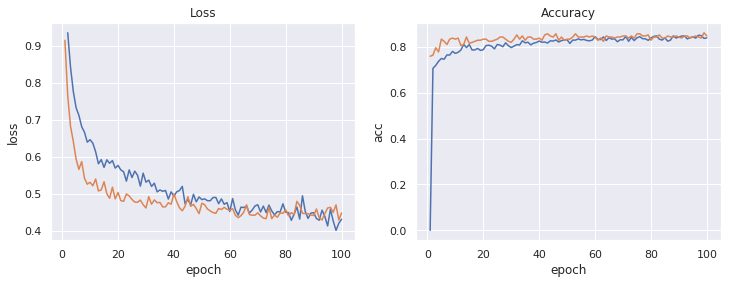

In [46]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(12,4))

axL.plot(df.epoch, df.train_loss, label='train')
axL.plot(df.epoch, df.val_loss, label='val')
axL.set_title('Loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.grid(True)

axR.plot(df.epoch, df.train_acc, label='train')
axR.plot(df.epoch, df.val_acc, label='val')
axR.set_title('Accuracy')
axR.set_xlabel('epoch')
axR.set_ylabel('acc')
axR.grid(True)

fig.show()

In [47]:
# #PyTorchのネットワークパラメータのロード
load_path = './weights/cat_vgg.pth'
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)

## CPU上で重みをロードする場合
#load_weights = torch.load(load_path, map_location={'cuda:0':'cpu'})
#net.load_state_dict(load_weights)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [48]:
net.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [49]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('使用デバイス',device)
# ネットワークをGPUへ
net.to(device)

for i, (inputs, labels) in enumerate(tqdm(dataloaders_dict['test'])):

    # GPUにデータを送る
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    ## 予測
    
    pred = net(inputs)
    ## softmaxにかけた後、確率最大を取り出す
    softmax = torch.nn.Softmax(dim=1)
    pred = torch.argmax(softmax(pred),dim=1)
    
    if i ==0:
        predict = pred
        true = labels
    else:
        predict = torch.cat((predict, pred),dim=0)
        true = torch.cat((true,labels),dim=0)
    

  0%|          | 0/8 [00:00<?, ?it/s]

使用デバイス cuda:0


100%|██████████| 8/8 [00:01<00:00,  5.31it/s]


0.8242677824267782
[[16  1  0  0  0  0  0  0  2  2  0  0]
 [ 2 15  0  0  0  2  1  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  3  0  0  0]
 [ 0  0  0 20  0  1  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  0  0  0  0]
 [ 0  4  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  1  0  0  0 13  2  0  0  1  0]
 [ 0  0  0  0  0  0  1 14  0  0  0  0]
 [ 0  0  1  0  0  0  5  4 15  0  0  0]
 [ 0  0  0  0  3  0  0  0  0 16  1  0]
 [ 1  0  1  0  0  0  0  0  0  0 18  0]
 [ 1  0  0  0  0  0  0  0  0  2  0 20]]


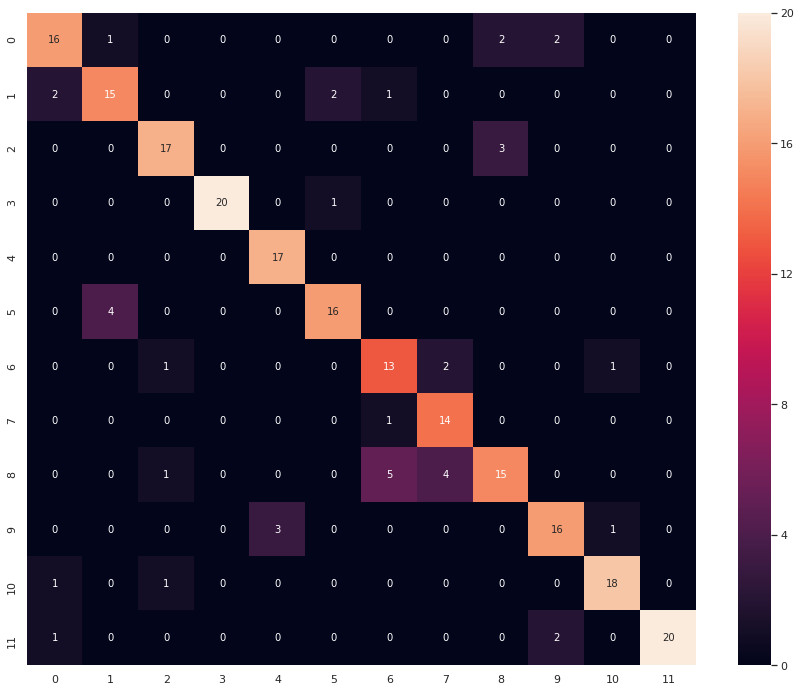

In [50]:
cm = confusion_matrix(predict.cpu(), true.cpu())
print(accuracy_score(predict.cpu(),true.cpu()))
print(cm)

plt.figure(figsize=(15,12))
sns.heatmap(cm, annot=True)